In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np

In [ ]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [ ]:
titanic_df = pd.read_csv(titanic_file)
titanic_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
features = titanic_df.drop("survived",axis=1)
labels = titanic_df["survived"]

In [ ]:
for col in features.columns:
    print(f"{col}: {features[col].map(type).unique()}")

sex: [<class 'str'>]
age: [<class 'float'>]
n_siblings_spouses: [<class 'int'>]
parch: [<class 'int'>]
fare: [<class 'float'>]
class: [<class 'str'>]
deck: [<class 'str'>]
embark_town: [<class 'str'>]
alone: [<class 'str'>]


In [ ]:
binary_features = []
numeric_features = ["age","fare"]
categorical_features = ["class","sex","deck","embark_town","alone","parch","n_siblings_spouses"]

In [ ]:
features.dtypes

,0
sex,object
age,float64
n_siblings_spouses,int64
parch,int64
fare,float64
class,object
deck,object
embark_town,object
alone,object


In [ ]:
inputs = {}
for name , column in dict(features).items():
  if name in categorical_features:
    if type(column[0]) is str:
      dtype = tf.string
    else:
      dtype = tf.int64
  else:
    dtype = tf.float32
  inputs[name] = keras.Input(shape=(1,),name=name,dtype=dtype)
preprocessed = []

In [ ]:
inputs

{'sex': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=sex>,
 'age': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=age>,
 'n_siblings_spouses': <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=n_siblings_spouses>,
 'parch': <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=parch>,
 'fare': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=fare>,
 'class': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=class>,
 'deck': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=deck>,
 'embark_town': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=embark_town>,
 'alone': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=alone>}

In [ ]:
normalizer = keras.layers.Normalization(axis=-1)
numeric_features_dict = {
    key : value.to_numpy()[:,tf.newaxis] for key,value in dict(features[numeric_features]).items()
}
# print(numeric_features_dict)
stacked_input = np.concatenate([
    value for key,value in sorted(numeric_features_dict.items())
],axis=-1)
normalizer.adapt(stacked_input)

In [ ]:
stacked_input

array([[22.    ,  7.25  ],
       [38.    , 71.2833],
       [26.    ,  7.925 ],
       ...,
       [19.    , 30.    ],
       [28.    , 23.45  ],
       [32.    ,  7.75  ]])

In [ ]:
numeric_inputs = []
for name in numeric_features:
  numeric_inputs.append(inputs[name])
numeric_inputs = keras.layers.concatenate(axis=-1,inputs=numeric_inputs)
normalized_numeric_inputs = normalizer(numeric_inputs)
preprocessed.append(normalized_numeric_inputs)

In [ ]:
for name in categorical_features:
  vocab = sorted(set(features[name]))
  lookup=None
  if type(vocab[0]) is str:
    lookup = keras.layers.StringLookup(vocabulary=vocab,output_mode="one_hot")
  else:
    lookup = keras.layers.IntegerLookup(vocabulary=vocab,output_mode="one_hot")
  x = inputs[name]
  x = lookup(x)
  preprocessed.append(x)

In [ ]:
preprocessed_results = keras.layers.concatenate(axis=-1,inputs=preprocessed)

In [ ]:
preprocessor = keras.Model(inputs, preprocessed_results)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((preprocessor(dict(features)),labels))
dataset = dataset.batch(32)

In [ ]:
for element in dataset.take(1):
  print

AttributeError: '_TakeDataset' object has no attribute 'numpy'

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units=16,activation="relu"),
    keras.layers.Dense(units=32,activation="relu"),
    keras.layers.Dense(units=1,activation="sigmoid")
])
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
)
model.fit(dataset,epochs=20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5927 - loss: 0.6833
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7424 - loss: 0.6246 
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.5740
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7426 - loss: 0.5318 
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.5024
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.4833 
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.4695
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.4589 
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7894 - loss: 0.4506
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7900 - loss: 0.4430
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.4369
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7968 

In [ ]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])
x = preprocessor(inputs)
result = body(x)
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

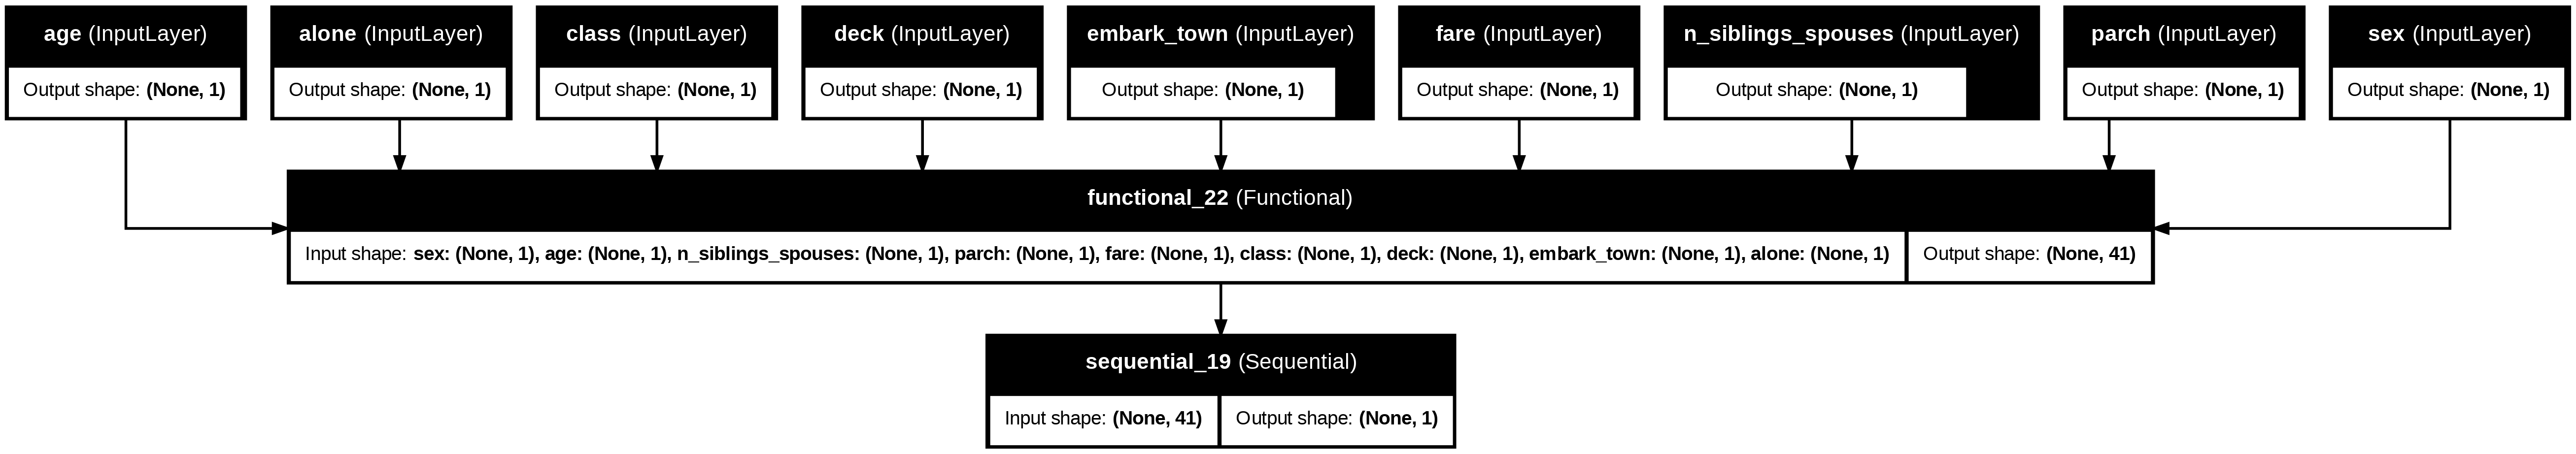

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True,  show_layer_names=True)

In [ ]:
history = model.fit(dict(features), labels, epochs=5, batch_size=20)

ValueError: Invalid dtype: object